In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
import joblib
import warnings
import lime
import lime.lime_tabular
from scipy.stats import zscore
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('C:\\Users\\TEJA\\Downloads\\KAG_energydata_complete1.csv')

In [5]:
df.head(2)

date  Appliances  lights     T1       RH_1    T2     RH_2  \
0  2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.7900   
1  2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.7225   

      T3   RH_3    T4  ...         T9   RH_9     T_out  Press_mm_hg  RH_out  \
0  19.79  44.73  19.0  ...  17.033333  45.53  6.600000        733.5    92.0   
1  19.79  44.79  19.0  ...  17.066667  45.56  6.483333        733.6    92.0   

   Windspeed  Visibility  Tdewpoint        rv1        rv2  
0   7.000000   63.000000        5.3  13.275433  13.275433  
1   6.666667   59.166667        5.2  18.606195  18.606195  

[2 rows x 29 columns]

In [6]:
df.columns = [x.lower() for x in df.columns]  # Convert column names to lowercase
df = df.set_index('date')  # Set 'date' as the index
df.index = pd.to_datetime(df.index) 
df = df.drop(df[(df.appliances > 790) | (df.appliances < 0)].index) 

In [7]:
df.shape

(19718, 28)

In [8]:
df.index = pd.to_datetime(df.index) 

In [9]:
df.isnull().sum()

appliances     0
lights         0
t1             0
rh_1           0
t2             0
rh_2           0
t3             0
rh_3           0
t4             0
rh_4           0
t5             0
rh_5           0
t6             0
rh_6           0
t7             0
rh_7           0
t8             0
rh_8           0
t9             0
rh_9           0
t_out          0
press_mm_hg    0
rh_out         0
windspeed      0
visibility     0
tdewpoint      0
rv1            0
rv2            0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19718 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   appliances   19718 non-null  int64  
 1   lights       19718 non-null  int64  
 2   t1           19718 non-null  float64
 3   rh_1         19718 non-null  float64
 4   t2           19718 non-null  float64
 5   rh_2         19718 non-null  float64
 6   t3           19718 non-null  float64
 7   rh_3         19718 non-null  float64
 8   t4           19718 non-null  float64
 9   rh_4         19718 non-null  float64
 10  t5           19718 non-null  float64
 11  rh_5         19718 non-null  float64
 12  t6           19718 non-null  float64
 13  rh_6         19718 non-null  float64
 14  t7           19718 non-null  float64
 15  rh_7         19718 non-null  float64
 16  t8           19718 non-null  float64
 17  rh_8         19718 non-null  float64
 18  t9         

In [11]:
df.describe()

appliances        lights            t1          rh_1            t2  \
count  19718.000000  19718.000000  19718.000000  19718.000000  19718.000000   
mean      97.025053      3.798053     21.686998     40.259441     20.341005   
std       99.969232      7.932437      1.605543      3.979260      2.192456   
min       10.000000      0.000000     16.790000     27.023333     16.100000   
25%       50.000000      0.000000     20.760000     37.333333     18.790000   
50%       60.000000      0.000000     21.600000     39.656667     20.000000   
75%      100.000000      0.000000     22.600000     43.066667     21.500000   
max      790.000000     70.000000     26.260000     63.360000     29.856667   

               rh_2            t3          rh_3            t4          rh_4  \
count  19718.000000  19718.000000  19718.000000  19718.000000  19718.000000   
mean      40.422084     22.267775     39.242653     20.855800     39.026816   
std        4.069852      2.004834      3.254918      2.042554      4.341882   
min       20.463333     17.200000     28.766667     15.100000     27.660000   
25%       37.900000     20.790000     36.900000     19.533333     35.530000   
50%       40.500000     22.100000     38.530000     20.666667     38.400000   
75%       43.260000     23.290000     41.760000     22.100000     42.156667   
max       56.026667     29.236000     50.163333     26.200000     51.090000   

       ...           t9          rh_9         t_out   press_mm_hg  \
count  ...  19718.00000  19718.000000  19718.000000  19718.000000   
mean   ...     19.48647     41.552516      7.412094    755.519644   
std    ...      2.01420      4.151664      5.316722      7.398882   
min    ...     14.89000     29.166667     -5.000000    729.300000   
25%    ...     18.00000     38.500000      3.666667    750.933333   
50%    ...     19.39000     40.900000      6.916667    756.100000   
75%    ...     20.60000     44.344464     10.400000    760.933333   
max    ...     24.50000     53.326667     26.100000    772.300000   

             rh_out     windspeed    visibility     tdewpoint           rv1  \
count  19718.000000  19718.000000  19718.000000  19718.000000  19718.000000   
mean      79.751564      4.040082     38.324433      3.761307     24.985960   
std       14.902563      2.451356     11.793961      4.194434     14.496784   
min       24.000000      0.000000      1.000000     -6.600000      0.005322   
25%       70.333333      2.000000     29.000000      0.900000     12.493131   
50%       83.666667      3.666667     40.000000      3.433333     24.893727   
75%       91.666667      5.500000     40.000000      6.566667     37.581331   
max      100.000000     14.000000     66.000000     15.500000     49.996530   

                rv2  
count  19718.000000  
mean      24.985960  
std       14.496784  
min        0.005322  
25%       12.493131  
50%       24.893727  
75%       37.581331  
max       49.996530  

[8 rows x 28 columns]

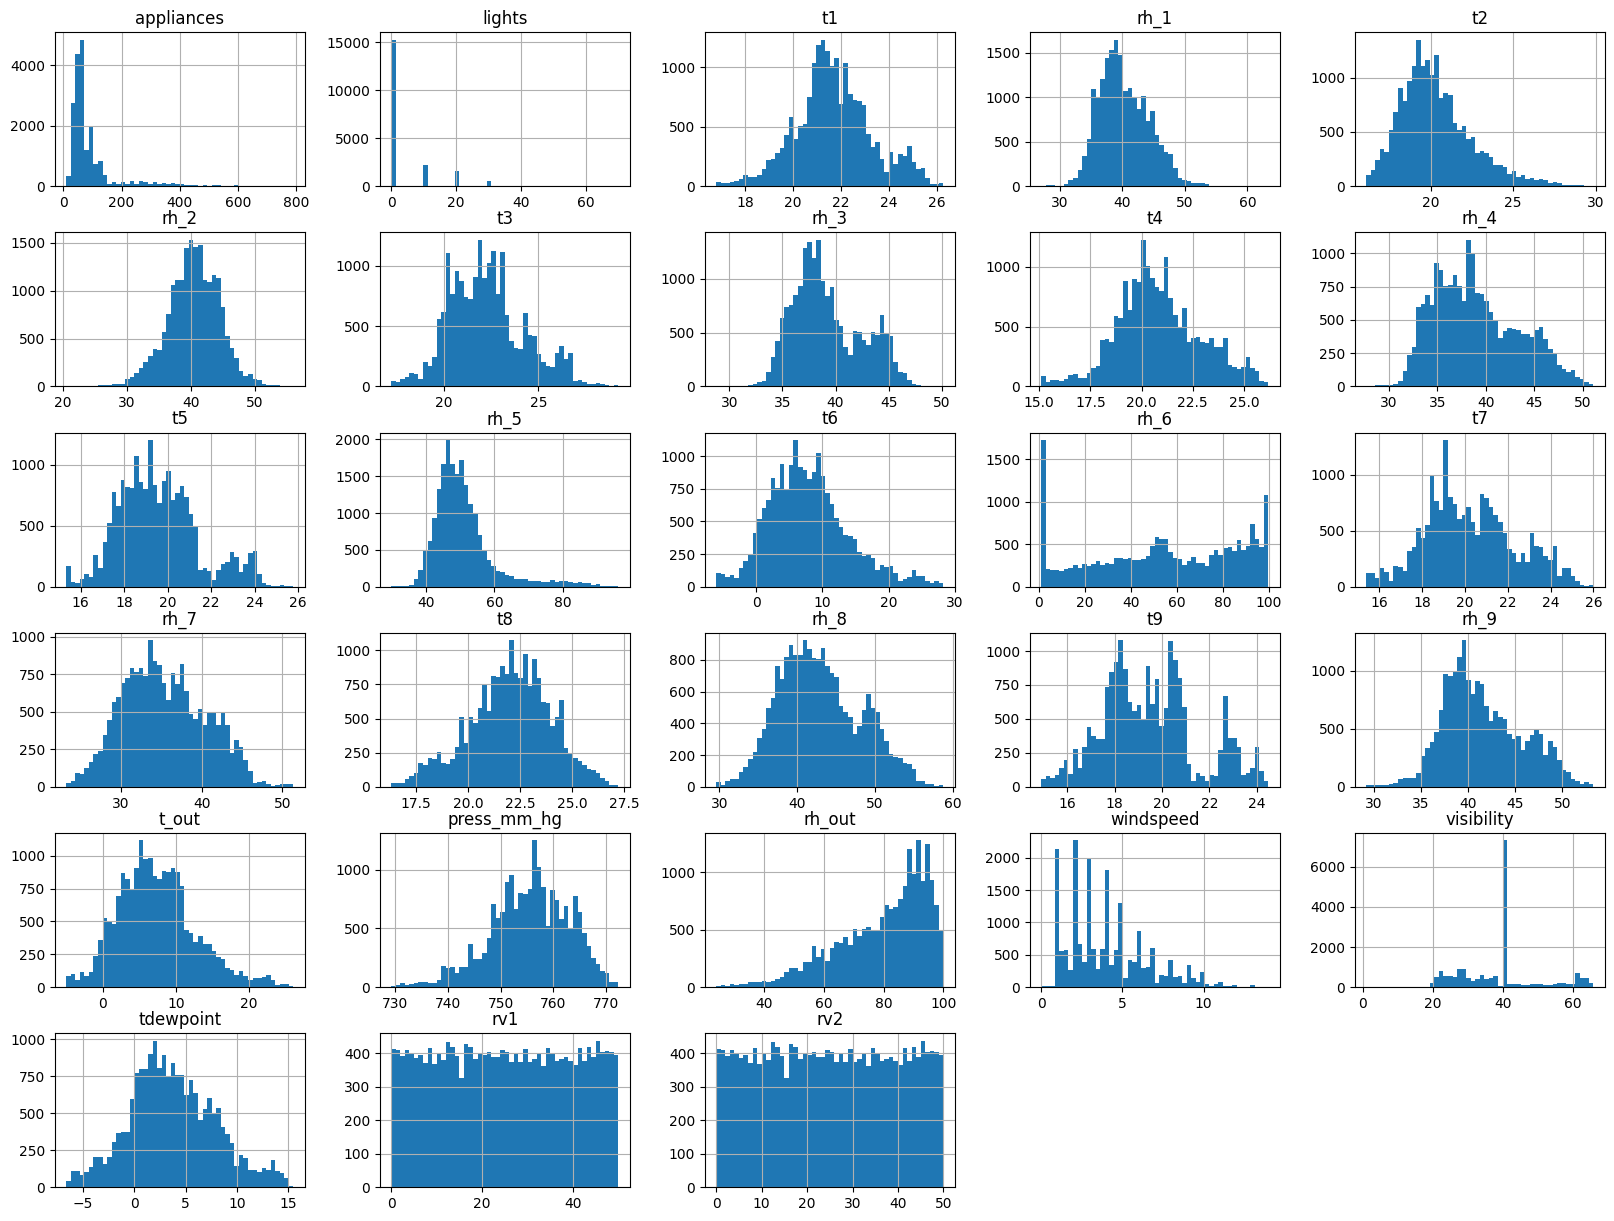

In [12]:
df.hist(bins=50, figsize=(20, 15))
plt.savefig('attribute_histogram_plots')
plt.show()

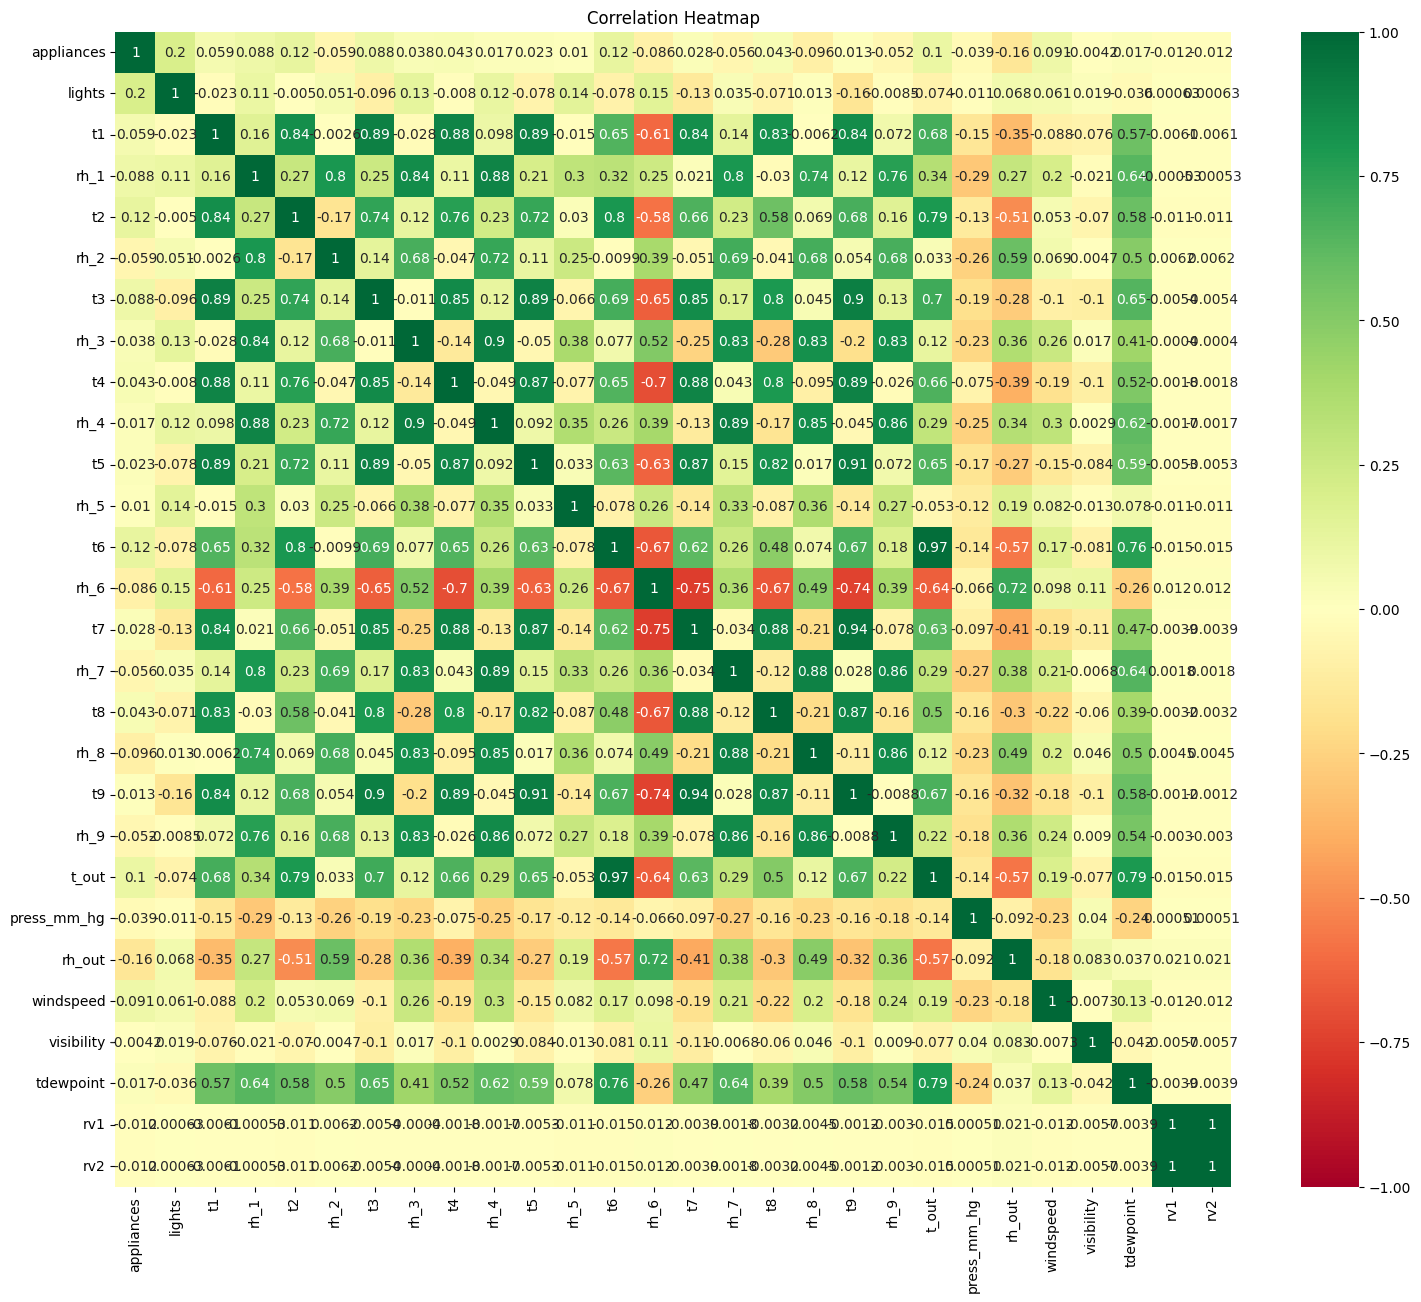

In [13]:
corr = df.corr()
plt.figure(figsize=(18, 15))
sns.heatmap(corr, annot=True, vmin=-1.0, cmap='RdYlGn')
plt.title("Correlation Heatmap")
plt.show()

In [14]:
sorted_appliances = df.sort_values('appliances', ascending=False)
df = df.drop(df[(df.appliances > 790) | (df.appliances < 0)].index)
sorted_appliances.head()

appliances  lights         t1       rh_1     t2  \
date                                                                   
2016-01-17 17:40:00         790      10  21.566667  38.626667  20.10   
2016-01-14 18:50:00         790      10  22.166667  40.500000  21.70   
2016-05-21 09:40:00         790       0  23.000000  50.260000  25.53   
2016-04-04 12:20:00         790       0  22.390000  45.563333  22.39   
2016-01-30 19:10:00         780       0  21.533333  45.860000  21.00   

                          rh_2         t3       rh_3         t4       rh_4  \
date                                                                         
2016-01-17 17:40:00  37.040909  20.790000  37.260000  21.066667  36.966667   
2016-01-14 18:50:00  38.626667  22.166667  42.133333  18.790000  44.626667   
2016-05-21 09:40:00  43.133333  24.390000  44.490000  23.600000  47.260000   
2016-04-04 12:20:00  42.966667  25.000000  41.433333  21.600000  43.590000   
2016-01-30 19:10:00  41.326667  21.760000  44.760000  21.356667  41.663333   

                     ...     t9       rh_9      t_out  press_mm_hg     rh_out  \
date                 ...                                                        
2016-01-17 17:40:00  ...  18.10  37.290000  -0.266667   764.833333  79.666667   
2016-01-14 18:50:00  ...  16.89  42.326667   4.083333   748.433333  76.833333   
2016-05-21 09:40:00  ...  23.00  47.462500  16.900000   756.333333  79.666667   
2016-04-04 12:20:00  ...  20.60  44.433333  13.466667   749.866667  68.666667   
2016-01-30 19:10:00  ...  16.29  44.530000   4.200000   754.100000  84.166667   

                     windspeed  visibility  tdewpoint        rv1        rv2  
date                                                                         
2016-01-17 17:40:00   2.000000   40.000000  -3.466667  36.170216  36.170216  
2016-01-14 18:50:00   6.833333   40.000000   0.350000  30.487447  30.487447  
2016-05-21 09:40:00   4.666667   28.333333  13.333333  44.856357  44.856357  
2016-04-04 12:20:00   7.000000   40.000000   7.766667   4.089491   4.089491  
2016-01-30 19:10:00   3.000000   37.833333   1.783333  26.838435  26.838435  

[5 rows x 28 columns]

In [15]:
len(sorted_appliances.head(len(sorted_appliances)//1000))

19

In [16]:
sorted_appliances.appliances[19]

np.int64(750)

In [17]:
sorted_appliances = df.sort_values('appliances',ascending=False)
print('The number of the 0,1% top values of appliance load is',
     len(sorted_appliances.head(len(sorted_appliances)//1000)),'and they have power load higher than',
      sorted_appliances.appliances[19],'Wh.')

The number of the 0,1% top values of appliance load is 19 and they have power load higher than 750 Wh.


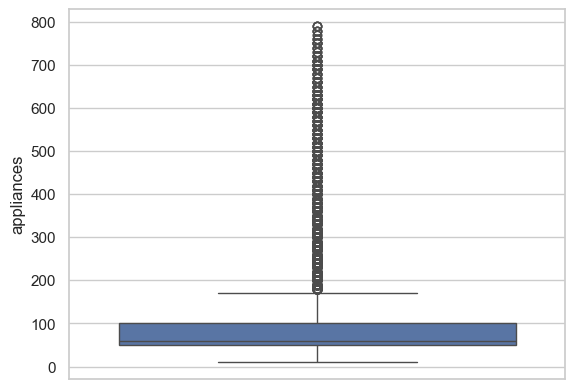

In [18]:
sns.set(style='whitegrid')
ax = sns.boxplot(sorted_appliances.appliances)

In [19]:
df = df.dropna()
df = df.drop(df[(df.appliances>790) | (df.appliances<0)].index)

In [20]:
df['hour'] = df.index.hour
df['week'] = df.index.isocalendar().week
df['weekday'] = df.index.weekday
df['month'] = df.index.month

In [21]:
df['log_appliances'] = np.log(df.appliances)

In [22]:
df['house_temp'] = (df.t1 + df.t2 + df.t3 + df.t4 + df.t5 + df.t7 + df.t8 + df.t9) / 8  

In [23]:
df['house_humd'] = (df.rh_1 + df.rh_2 + df.rh_3 + df.rh_4 + df.rh_5 + df.rh_7 + df.rh_8 + df.rh_9) / 8 

In [24]:
df['hour*lights'] = df.hour * df.lights
df['t3rh3'] = df.t3 * df.rh_3
df['t2rh2'] = df.t2 * df.rh_2
df['t1rh1'] = df.t1 * df.rh_1
df['t4rh4'] = df.t4 * df.rh_4
df['t5rh5'] = df.t5 * df.rh_5
df['t6rh6'] = df.t6 * df.rh_6
df['t7rh7'] = df.t7 * df.rh_7
df['t8rh8'] = df.t8 * df.rh_8
df['t9rh9'] = df.t9 * df.rh_9

In [25]:
# Add weekday and hour averages
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

df['weekday_avg'] = list(map(code_mean(df[:], 'weekday', 'appliances').get, df.weekday))
df['hour_avg'] = list(map(code_mean(df[:], 'hour', 'appliances').get, df.hour))

In [26]:
# Resample data
df_hour = df.resample('1H').mean()  # Resample to hourly data
df_30min = df.resample('30min').mean()  # Resample to 30-minute data

In [27]:
# Add low and high consumption flags
df_hour['low_consum'] = (df_hour.appliances + 25 < (df_hour.hour_avg)) * 1
df_hour['high_consum'] = (df_hour.appliances + 25 > (df_hour.hour_avg)) * 1

In [28]:
# One-hot encoding for categorical features
for cat_feature in ['weekday', 'hour']:
    df_hour = pd.concat([df_hour, pd.get_dummies(df_hour[cat_feature], prefix=cat_feature)], axis=1)
    df_30min = pd.concat([df_30min, pd.get_dummies(df_30min[cat_feature], prefix=cat_feature)], axis=1)
    df = pd.concat([df, pd.get_dummies(df[cat_feature], prefix=cat_feature)], axis=1)


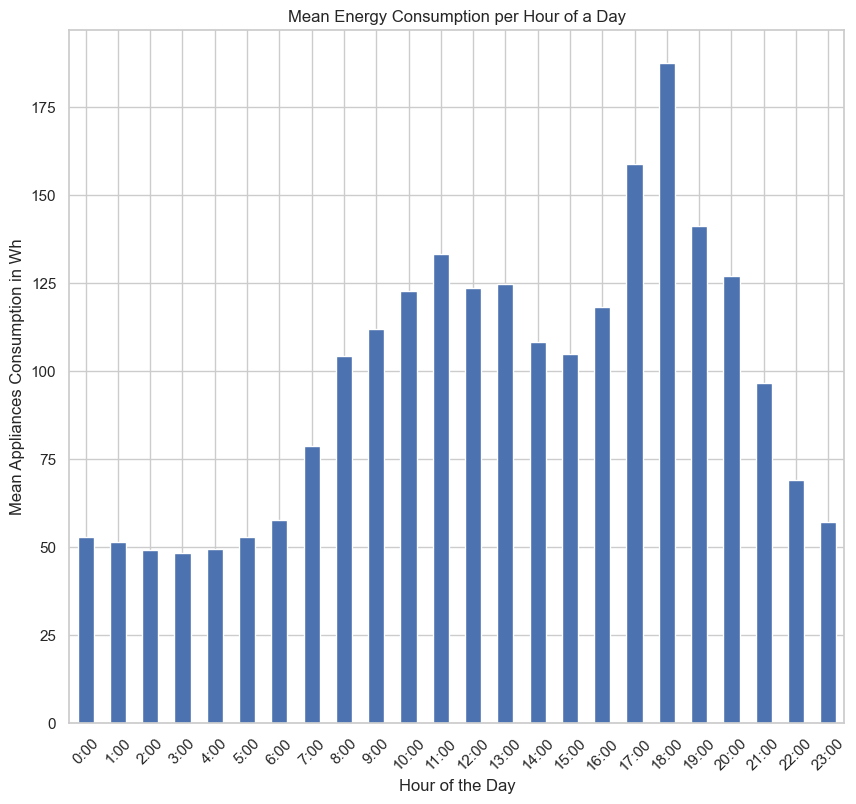

In [29]:
hourly_group = df.groupby('hour')['appliances'].mean()


plt.figure(figsize=(10, 9))
hourly_group.plot(kind='bar')  
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Appliances Consumption in Wh')
plt.title('Mean Energy Consumption per Hour of a Day')
plt.xticks(ticks=range(0, 24), labels=[f'{h}:00' for h in range(24)], rotation=45)
plt.grid(True)
plt.show()

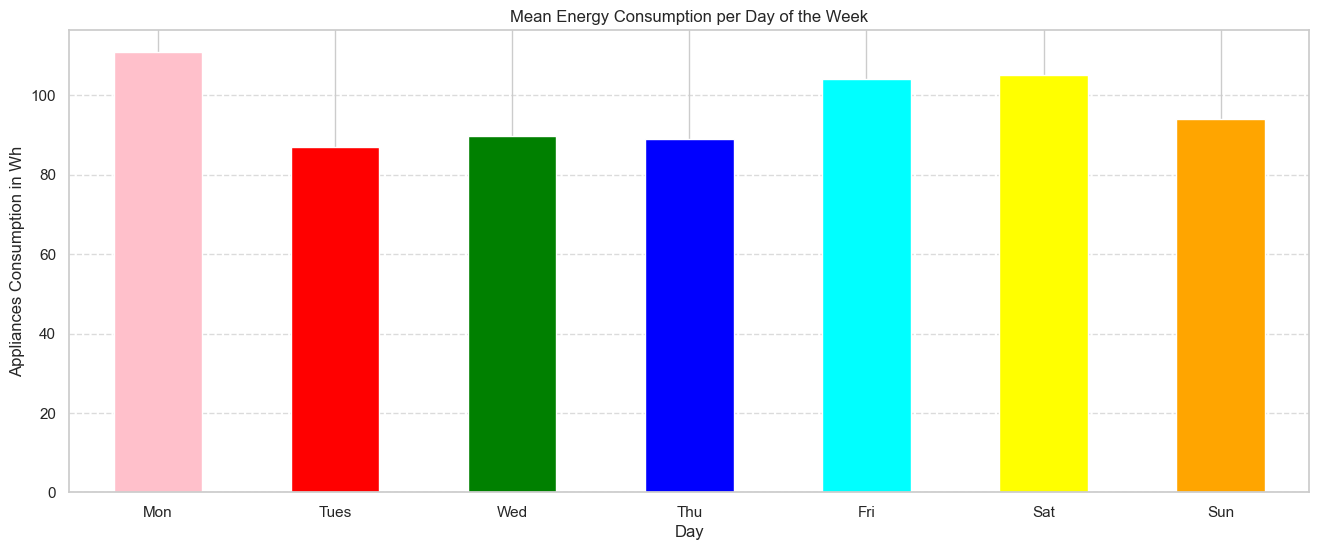

In [30]:

df['weekday'] = df.index.weekday  


daily_consumption = df.groupby('weekday')['appliances'].mean()


plt.figure(figsize=(16, 6))
daily_consumption.plot(kind='bar', color=['pink', 'red', 'green', 'blue', 'cyan', 'yellow', 'orange'])


ticks = list(range(0, 7))  
labels = 'Mon Tues Wed Thu Fri Sat Sun'.split() 
plt.xticks(ticks, labels, rotation=0)  

plt.xlabel('Day')
plt.ylabel('Appliances Consumption in Wh')
plt.title('Mean Energy Consumption per Day of the Week')


plt.grid(True, axis='y', linestyle='--', alpha=0.7)


plt.show()

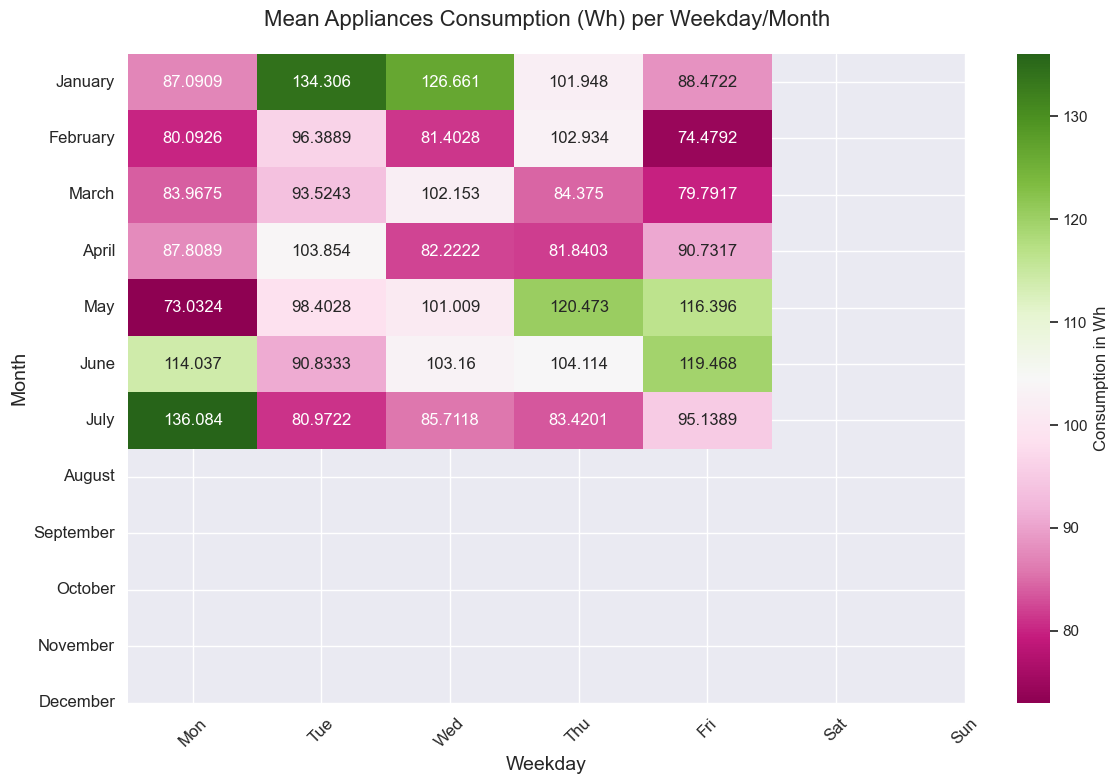

In [31]:
# Group by month and weekday, then calculate the mean of appliances
monthly_daily = df.groupby(['month', 'weekday'])['appliances'].mean().unstack()

# Set the figure size
sns.set(rc={'figure.figsize': (12, 8)})

# Create the heatmap
ax = sns.heatmap(
    monthly_daily.T,  # Transpose the DataFrame to have weekdays as columns and months as rows
    cmap='PiYG',  # Color map
    xticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],  # Weekday labels
    yticklabels=['January', 'February', 'March', 'April', 'May', 'June', 
                 'July', 'August', 'September', 'October', 'November', 'December'],  # Month labels
    annot=True,  # Annotate each cell with the value
    fmt='g',  # Format annotations as general numbers
    cbar_kws={'label': 'Consumption in Wh'}  # Add a label to the color bar
)

# Set the title of the heatmap
ax.set_title('Mean Appliances Consumption (Wh) per Weekday/Month', fontsize=16, pad=20)

# Label the x-axis and y-axis
ax.set_xlabel('Weekday', fontsize=14)
ax.set_ylabel('Month', fontsize=14)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout to make sure everything fits without overlapping
plt.tight_layout()

# Display the heatmap
plt.show()


Text(0.5, 0, 'Appliance Log Wh')

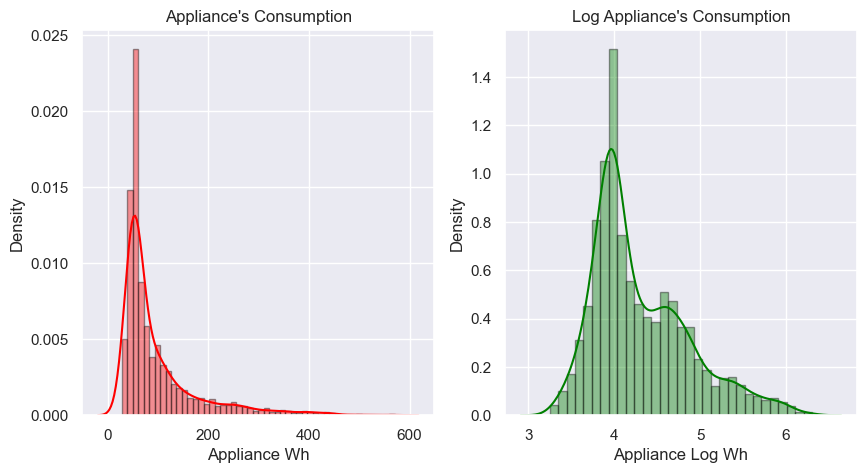

In [32]:
f, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.distplot(df_hour.appliances, hist=True, color='red', hist_kws={'edgecolor': 'black'}, ax=axes[0])
axes[0].set_title("Appliance's Consumption")
axes[0].set_xlabel("Appliance Wh")

sns.distplot(df_hour.log_appliances, hist=True, color='green', hist_kws={'edgecolor': 'black'}, ax=axes[1])
axes[1].set_title("Log Appliance's Consumption")
axes[1].set_xlabel("Appliance Log Wh")

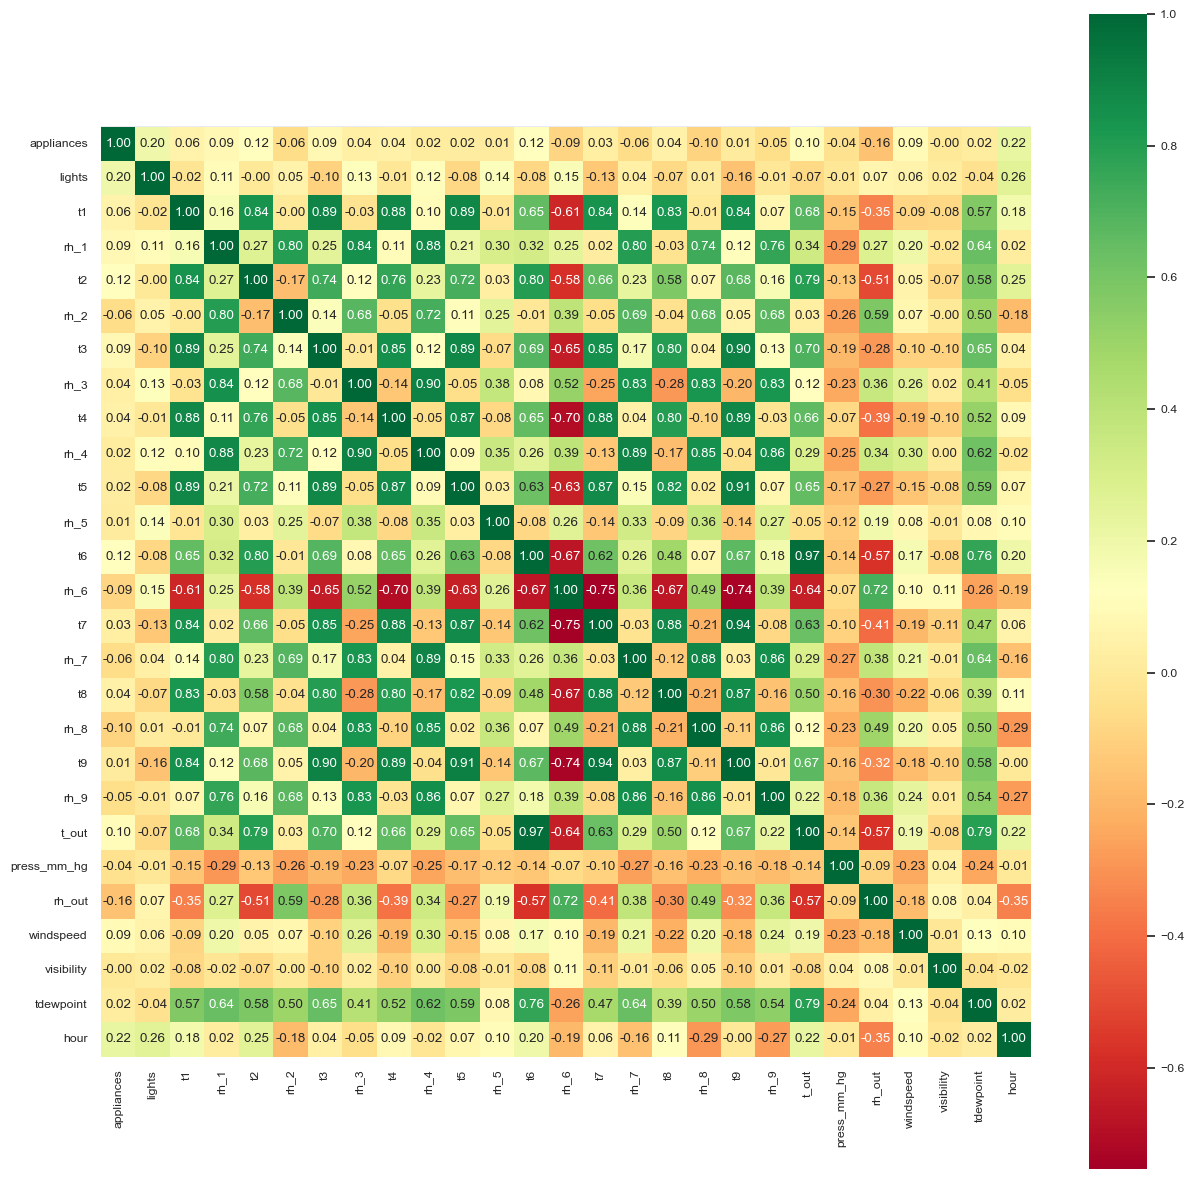

In [33]:
col = ['appliances', 'lights', 't1', 'rh_1', 't2', 'rh_2', 't3', 'rh_3', 't4', 'rh_4', 't5', 'rh_5', 't6', 'rh_6', 't7', 'rh_7', 't8', 'rh_8', 't9', 'rh_9', 't_out', 'press_mm_hg', 'rh_out', 'windspeed', 'visibility', 'tdewpoint', 'hour']
corr = df[col].corr()
plt.figure(figsize=(15, 15))
sns.set(font_scale=0.8)
sns.heatmap(corr, cbar=True, annot=True, square=True, cmap='RdYlGn', fmt='.2f', xticklabels=col, yticklabels=col)
plt.show()

In [34]:
for cat_feature in ['weekday', 'hour']:
    df_hour = pd.concat([df_hour, pd.get_dummies(df_hour[cat_feature])], axis=1)
    df_30min = pd.concat([df_30min, pd.get_dummies(df_30min[cat_feature])], axis=1)
    df = pd.concat([df, pd.get_dummies(df[cat_feature])], axis=1)

In [35]:
# Create interaction features
for i in range(1, 10):
    df[f't{i}rh{i}'] = df[f't{i}'] * df[f'rh_{i}']

# Create rolling statistics and lag features
df['appliances_lag1'] = df['appliances'].shift(1)  # Lag feature
df['appliances_rolling_mean'] = df['appliances'].rolling(window=3).mean()  # Rolling mean

# Remove rows with missing values
df = df.dropna()

# Resample data to hourly
df_hour = df.resample('1H').mean()

# Add low and high consumption flags
df_hour['low_consum'] = (df_hour.appliances + 25 < (df_hour.appliances_rolling_mean)) * 1
df_hour['high_consum'] = (df_hour.appliances + 25 > (df_hour.appliances_rolling_mean)) * 1

# Define features and target
features = ['low_consum', 'high_consum', 'hour', 't6', 'rh_6', 'lights', 'appliances_lag1', 'appliances_rolling_mean', 'windspeed', 't6rh6']
target = 'log_appliances'

# Train-test split
test_size = 0.2
test_index = int(len(df_hour) * (1 - test_size))
X_train, X_test = df_hour[features].iloc[:test_index], df_hour[features].iloc[test_index:]
y_train, y_test = df_hour[target].iloc[:test_index], df_hour[target].iloc[test_index:]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [36]:
# Evaluate model
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    rscore = 100 * r2_score(test_labels, predictions)
    accuracy = 100 - mape
    print(model, '\n')
    print('Average Error          :{:0.4f} degrees'.format(np.mean(errors)))
    print('Variance Score         :{:0.2f}%'.format(rscore))
    print('Accuracy               :{:0.2f}%'.format(accuracy))

evaluate(rf_model, X_test_scaled, y_test)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 0.5, 0.7],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)
best_params = grid_search.best_params_
print("Best Parameters for Random Forest:", best_params)

# Train tuned model
tuned_rf_model = RandomForestRegressor(**best_params, random_state=42)
tuned_rf_model.fit(X_train_scaled, y_train)
evaluate(tuned_rf_model, X_test_scaled, y_test)

# Cross-validation
tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(tuned_rf_model, X_train_scaled, y_train, cv=tscv, scoring='neg_mean_squared_error')
print(f"Cross-Validation MSE: {-scores.mean()}")

RandomForestRegressor(random_state=42) 

Average Error          :0.0536 degrees
Variance Score         :97.53%
Accuracy               :98.80%
Fitting 3 folds for each of 540 candidates, totalling 1620 fits
Best Parameters for Random Forest: {'max_depth': 20, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
RandomForestRegressor(max_depth=20, max_features=0.5, n_estimators=500,
                      random_state=42) 

Average Error          :0.0501 degrees
Variance Score         :97.80%
Accuracy               :98.88%
Cross-Validation MSE: 0.008124225422390413


In [37]:
y_pred = rf_model.predict(X_test)

Text(0.5, 0.01, 'Fitted Values')

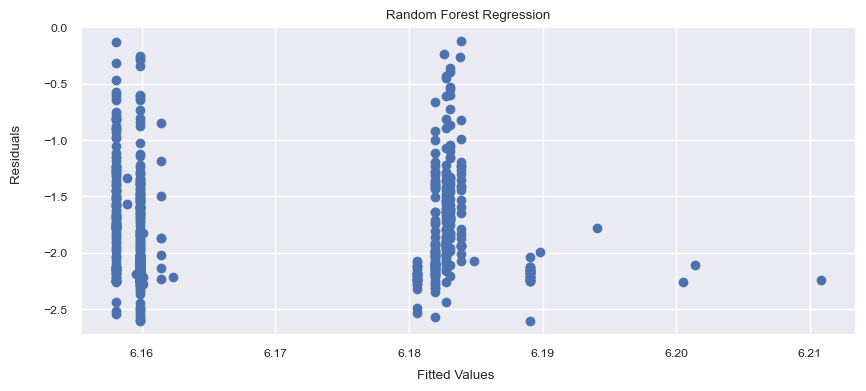

In [38]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(y_pred, y_test - y_pred)
ax.set_title('Random Forest Regression')
fig.text(0.06, 0.5, 'Residuals', ha='center', rotation='vertical')
fig.text(0.5, 0.01, 'Fitted Values', ha='center', va='center')

Text(0.5, 0.01, 'Fitted Values')

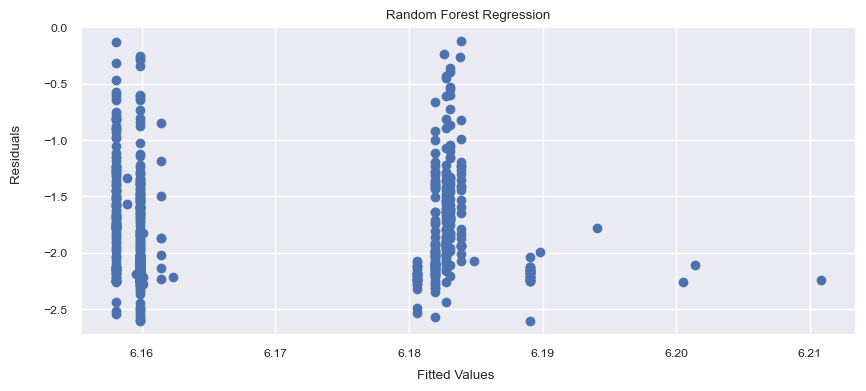

In [39]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(y_pred, y_test - y_pred)
ax.set_title('Random Forest Regression')
fig.text(0.06, 0.5, 'Residuals', ha='center', rotation='vertical')
fig.text(0.5, 0.01, 'Fitted Values', ha='center', va='center')

In [40]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)
evaluate(xgb_model, X_test, y_test)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...) 

Average Error          :0.0480 degrees
Variance Score         :97.94%
Accuracy               :98.93%


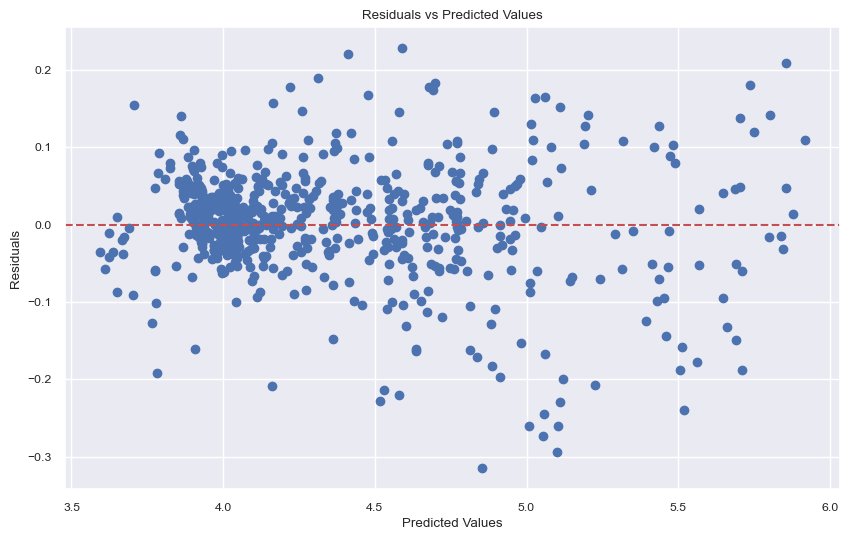

In [41]:
# Residual analysis
y_pred = tuned_rf_model.predict(X_test_scaled)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

In [42]:
# Feature importance
importances = tuned_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

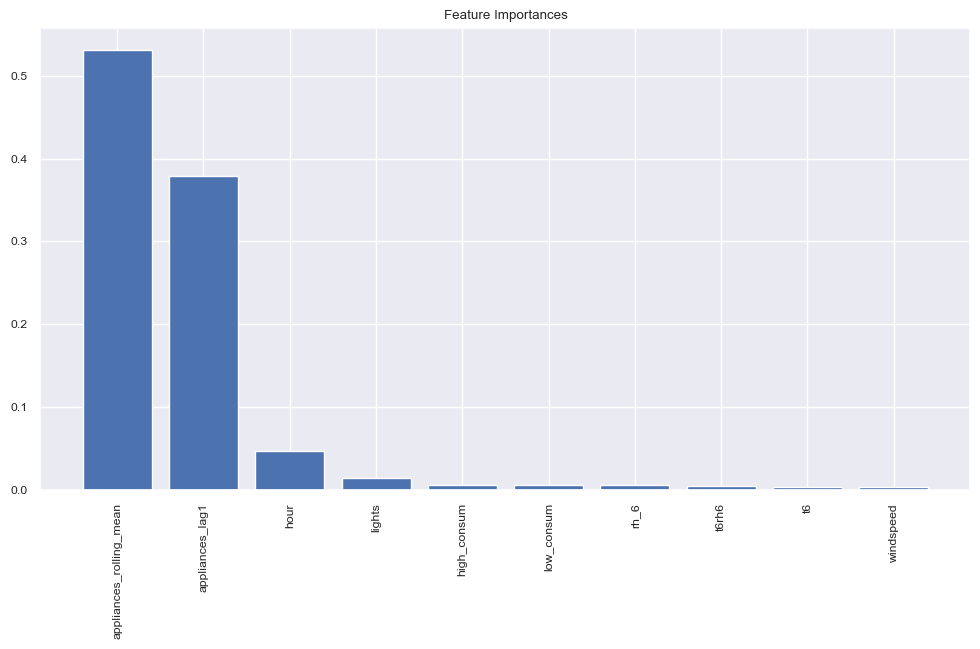

In [43]:
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), np.array(features)[indices], rotation=90)
plt.show()

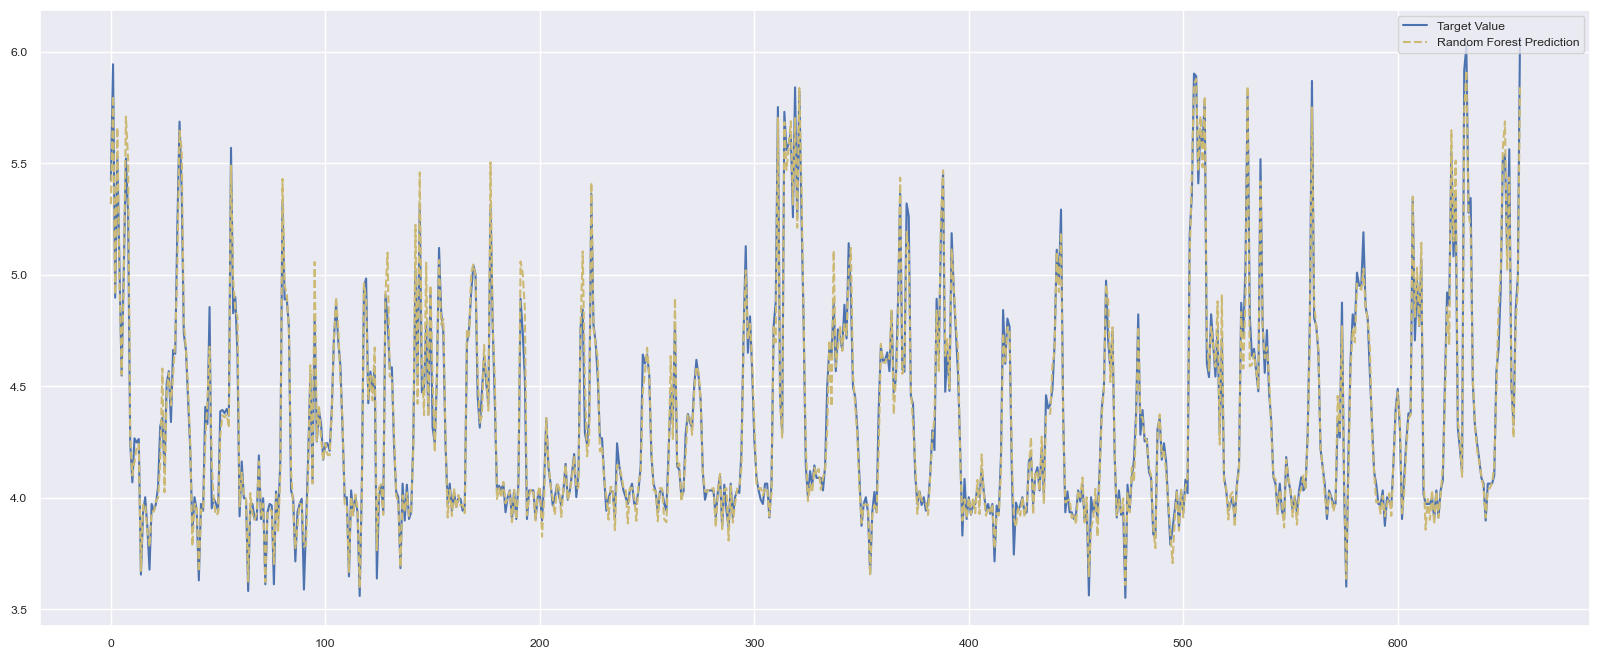

In [44]:
fig = plt.figure(figsize=(20,8))
plt.plot(y_test.values,label='Target Value',color='b')
plt.plot(y_pred,label='Random Forest Prediction',linestyle='--',color='y')
plt.legend(loc=1)

In [45]:
joblib.dump(tuned_rf_model, 'tuned_rf_model.pkl')

['tuned_rf_model.pkl']

In [46]:
# Predict for daily, weekly, and monthly consumption
df_pred = df_hour.copy()
df_pred['day'] = df_pred.index.day
df_pred['week'] = df_pred.index.isocalendar().week
df_pred['month'] = df_pred.index.month

In [47]:
def predict_consumption(df, time_period):
    X = df[features]
    X_scaled = scaler.transform(X)  # Scale features
    predictions = tuned_rf_model.predict(X_scaled)
    df[f'predicted_{time_period}'] = np.exp(predictions)  # Convert back from log scale
    return df

In [48]:
# Predict for daily, weekly, and monthly
df_daily = predict_consumption(df_pred.groupby('day').mean().reset_index(), 'daily')
df_weekly = predict_consumption(df_pred.groupby('week').mean().reset_index(), 'weekly')
df_monthly = predict_consumption(df_pred.groupby('month').mean().reset_index(), 'monthly')

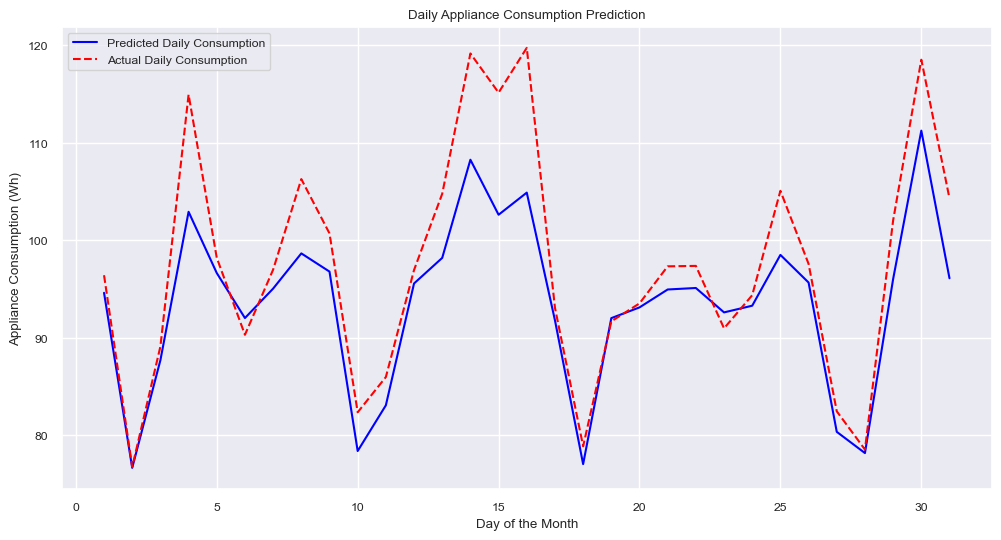

In [49]:
# Plot daily predictions
plt.figure(figsize=(12, 6))
plt.plot(df_daily['day'], df_daily['predicted_daily'], label='Predicted Daily Consumption', color='blue')
plt.plot(df_daily['day'], df_daily['appliances'], label='Actual Daily Consumption', color='red', linestyle='--')
plt.title('Daily Appliance Consumption Prediction')
plt.xlabel('Day of the Month')
plt.ylabel('Appliance Consumption (Wh)')
plt.legend()
plt.grid(True)
plt.show()

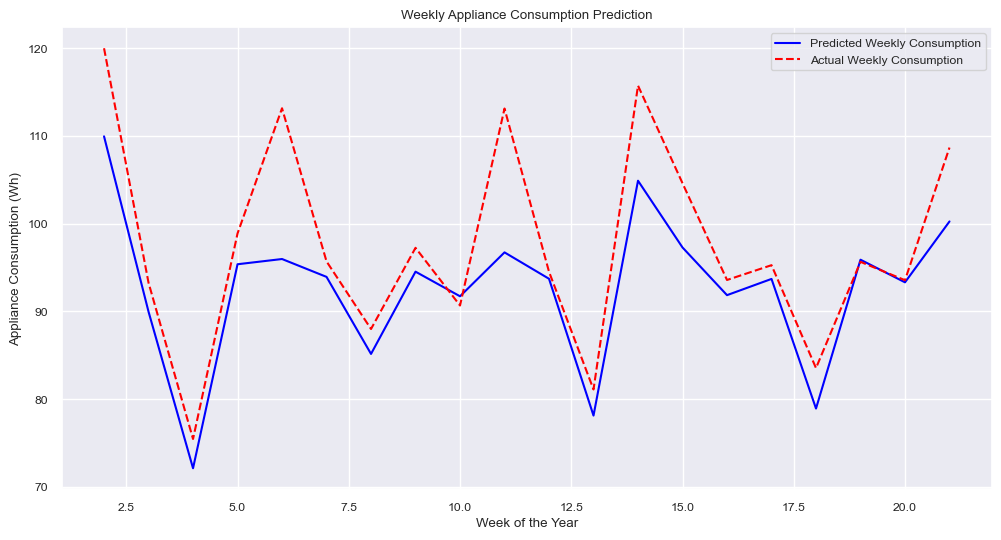

In [50]:
# Plot weekly predictions
plt.figure(figsize=(12, 6))
plt.plot(df_weekly['week'], df_weekly['predicted_weekly'], label='Predicted Weekly Consumption', color='blue')
plt.plot(df_weekly['week'], df_weekly['appliances'], label='Actual Weekly Consumption', color='red', linestyle='--')
plt.title('Weekly Appliance Consumption Prediction')
plt.xlabel('Week of the Year')
plt.ylabel('Appliance Consumption (Wh)')
plt.legend()
plt.grid(True)
plt.show()

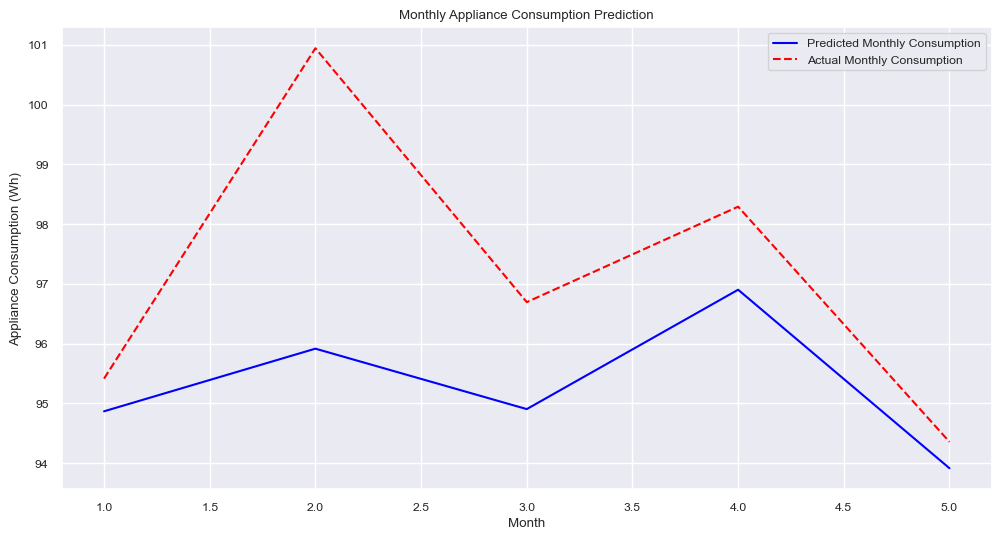

In [51]:
# Plot monthly predictions
plt.figure(figsize=(12, 6))
plt.plot(df_monthly['month'], df_monthly['predicted_monthly'], label='Predicted Monthly Consumption', color='blue')
plt.plot(df_monthly['month'], df_monthly['appliances'], label='Actual Monthly Consumption', color='red', linestyle='--')
plt.title('Monthly Appliance Consumption Prediction')
plt.xlabel('Month')
plt.ylabel('Appliance Consumption (Wh)')
plt.legend()
plt.grid(True)
plt.show()


In [52]:
# Evaluate predictions
daily_mse = mean_squared_error(df_daily['appliances'], df_daily['predicted_daily'])
daily_r2 = r2_score(df_daily['appliances'], df_daily['predicted_daily'])
print(f"Daily Predictions - MSE: {daily_mse}, R2: {daily_r2}")

Daily Predictions - MSE: 33.08757530060372, R2: 0.7591142839389413


In [53]:
weekly_mse = mean_squared_error(df_weekly['appliances'], df_weekly['predicted_weekly'])
weekly_r2 = r2_score(df_weekly['appliances'], df_weekly['predicted_weekly'])
print(f"Weekly Predictions - MSE: {weekly_mse}, R2: {weekly_r2}")

monthly_mse = mean_squared_error(df_monthly['appliances'], df_monthly['predicted_monthly'])
monthly_r2 = r2_score(df_monthly['appliances'], df_monthly['predicted_monthly'])
print(f"Monthly Predictions - MSE: {monthly_mse}, R2: {monthly_r2}")

Weekly Predictions - MSE: 49.899818251726984, R2: 0.6251934345962383
Monthly Predictions - MSE: 6.186726863103733, R2: -0.15667964196121376


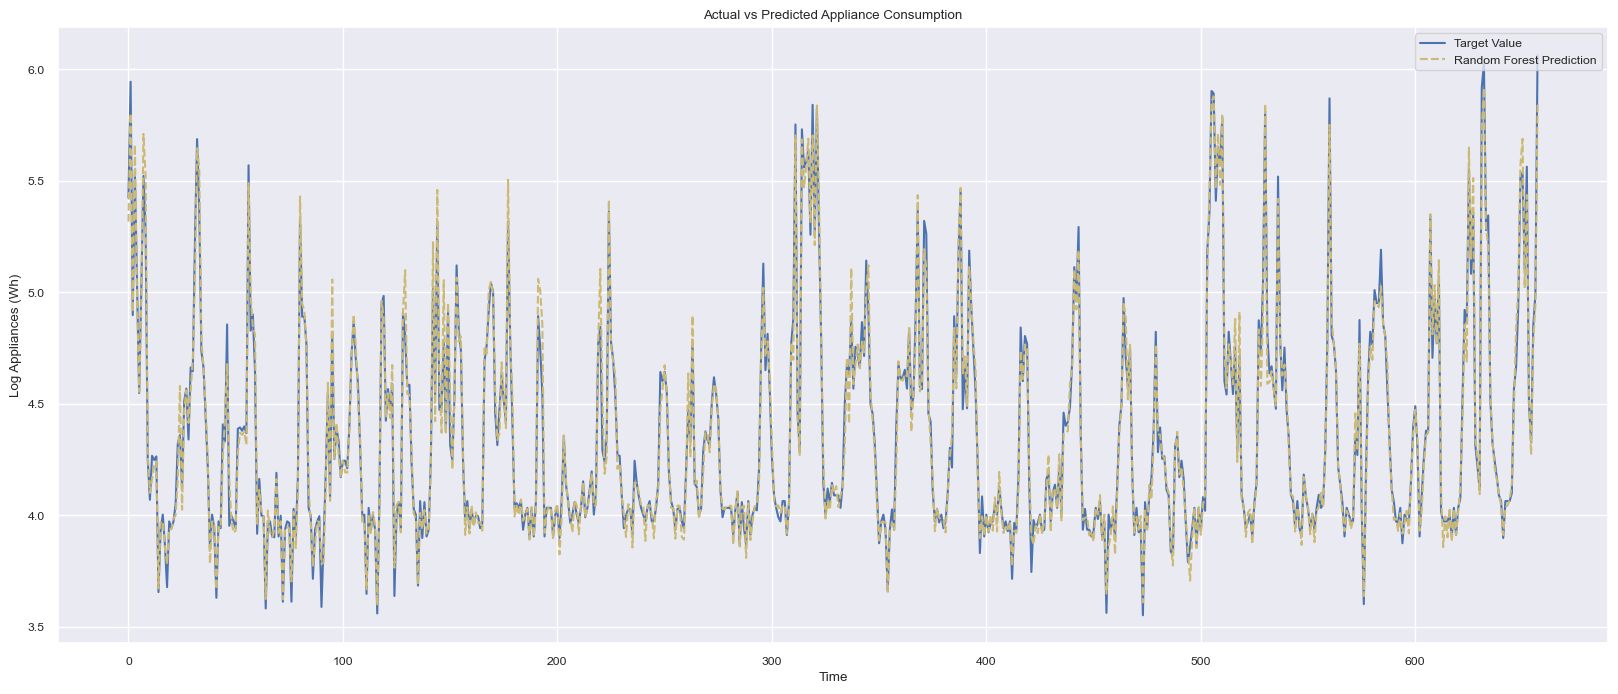

In [54]:

fig = plt.figure(figsize=(20, 8))
plt.plot(y_test.values, label='Target Value', color='b')
plt.plot(y_pred, label='Random Forest Prediction', linestyle='--', color='y')
plt.legend(loc=1)
plt.title('Actual vs Predicted Appliance Consumption')
plt.xlabel('Time')
plt.ylabel('Log Appliances (Wh)')
plt.show()

In [55]:
# Explain predictions using LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_scaled,  # Use scaled training data
    feature_names=features,  # Use the correct feature names
    class_names=['log_appliances'],  # Target variable name
    verbose=True,  # Print progress
    mode='regression'  # Set mode to regression
)


In [56]:
# Select an instance from the test set to explain
instance_index = 0  # Index of the instance to explain
instance = X_test_scaled[instance_index]  # Use scaled test data

In [57]:
# Explain the prediction for the selected instance
exp = explainer.explain_instance(
    instance,  # Instance to explain
    tuned_rf_model.predict,  # Model's prediction function
    num_features=len(features)  # Number of features to include in the explanation
)

Intercept 3.92543950282393
Prediction_local [5.1905156]
Right: 5.317255134011717


In [58]:
# Display the explanation in the notebook
exp.show_in_notebook()

In [59]:
def provide_recommendation(current_consumption, hourly_avg_consumption):
    """
    Provide recommendations based on current consumption.
    
    Parameters:
        current_consumption (float): Current appliance consumption.
        hourly_avg_consumption (float): Average hourly consumption.
    
    Returns:
        str: Recommendation message.
    """
    if current_consumption > hourly_avg_consumption * 1.2:  # 20% higher than average
        return "High consumption detected! Consider reducing usage of heavy appliances during peak hours."
    elif current_consumption < hourly_avg_consumption * 0.8:  # 20% lower than average
        return "Low consumption detected. This is a good time to use heavy appliances like washing machines or dishwashers."
    else:
        return "Consumption is within normal range. No action required."

In [60]:
# Calculate hourly average consumption
hourly_avg_consumption = df_hour.groupby('hour')['appliances'].mean()

In [61]:
# Example: Predict consumption for a specific hour and provide recommendations
def predict_and_recommend(hour, model, scaler, hourly_avg_consumption):
    """
    Predict consumption for a specific hour and provide recommendations.
    
    Parameters:
        hour (int): Hour of the day (0-23).
        model: Trained model.
        scaler: Fitted scaler.
        hourly_avg_consumption: Average hourly consumption.
    
    Returns:
        dict: Prediction and recommendation.
    """
    # Create a sample input for the specified hour
    sample_input = df_hour[df_hour['hour'] == hour].iloc[0:1][features]
    sample_input_scaled = scaler.transform(sample_input)
    
    # Predict consumption
    predicted_consumption = np.exp(model.predict(sample_input_scaled))  # Convert back from log scale
    
    # Get recommendation
    recommendation = provide_recommendation(predicted_consumption[0], hourly_avg_consumption[hour])
    
    return {
        'hour': hour,
        'predicted_consumption': predicted_consumption[0],
        'recommendation': recommendation
    }

# Example usage
hour_to_predict = 18  # 6 PM
result = predict_and_recommend(hour_to_predict, tuned_rf_model, scaler, hourly_avg_consumption)
print(f"Hour: {result['hour']}:00")
print(f"Predicted Consumption: {result['predicted_consumption']:.2f} Wh")
print(f"Recommendation: {result['recommendation']}")

Hour: 18:00
Predicted Consumption: 109.19 Wh
Recommendation: Low consumption detected. This is a good time to use heavy appliances like washing machines or dishwashers.


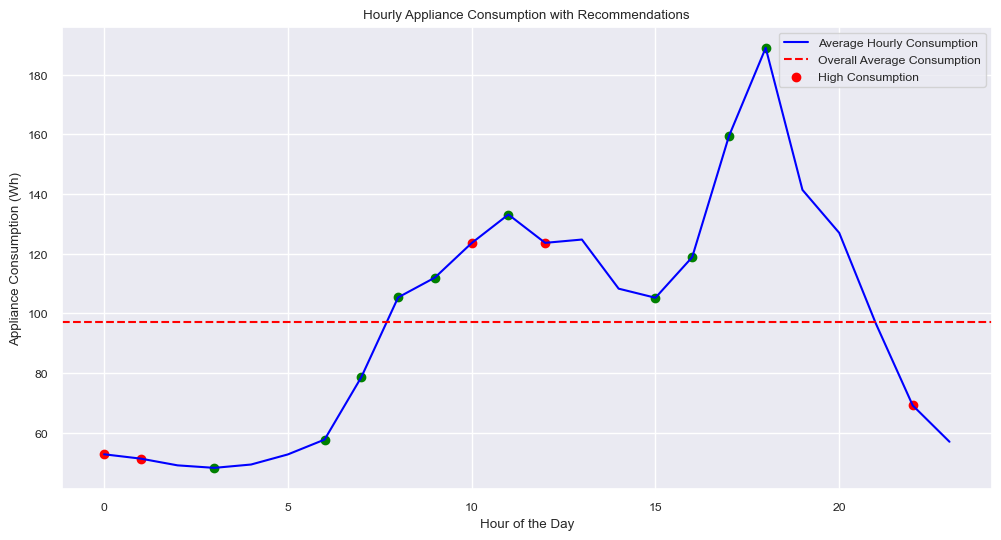